In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
#--------------------------------------------------------------------------------
# Descargamos el conjunto de datos de Fashion MNIST de Zalando
#--------------------------------------------------------------------------------
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [ ]:
#--------------------------------------------------------------------------------
# Mostramos los metadatos para ver que trae el conjunto de datos
#--------------------------------------------------------------------------------
metadatos

In [ ]:
#--------------------------------------------------------------------------------
# Obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
#--------------------------------------------------------------------------------
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [ ]:
#--------------------------------------------------------------------------------
# Etiquetas de las 10 categorias posibles
#--------------------------------------------------------------------------------
nombres_clases = metadatos.features['label'].names
nombres_clases

In [ ]:
#--------------------------------------------------------------------------------
# Renombramos los tipos de datos
#--------------------------------------------------------------------------------
nombres_clases = [ 'Camiseta/top', 'Pantalón', 'Jersey', 'Vestido', 'Abrigo', 'Sandalia', 'Camisa', 'Zapailla de deporte', 'Bolsa', 'Botín' ]
nombres_clases

In [ ]:
#--------------------------------------------------------------------------------
# Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1)
# Hace que la red aprenda mejor y mas rapido
#--------------------------------------------------------------------------------
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

#--------------------------------------------------------------------------------
# Normalizamos los datos de entrenamiento y pruebas con la funcion que hicimos
#--------------------------------------------------------------------------------
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#--------------------------------------------------------------------------------
# Agregamos a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
#--------------------------------------------------------------------------------
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

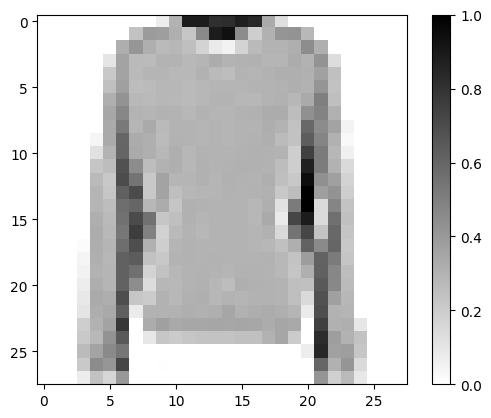

In [ ]:
#--------------------------------------------------------------------------------
# Mostramos una imagen de los datos de pruebas, de momento mostremos la primera
#--------------------------------------------------------------------------------
for imagen, etiqueta in datos_entrenamiento.take(1):
  break
imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos despues

import matplotlib.pyplot as plt

#--------------------------------------------------------------------------------
# Mostramos una imagen
#--------------------------------------------------------------------------------
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

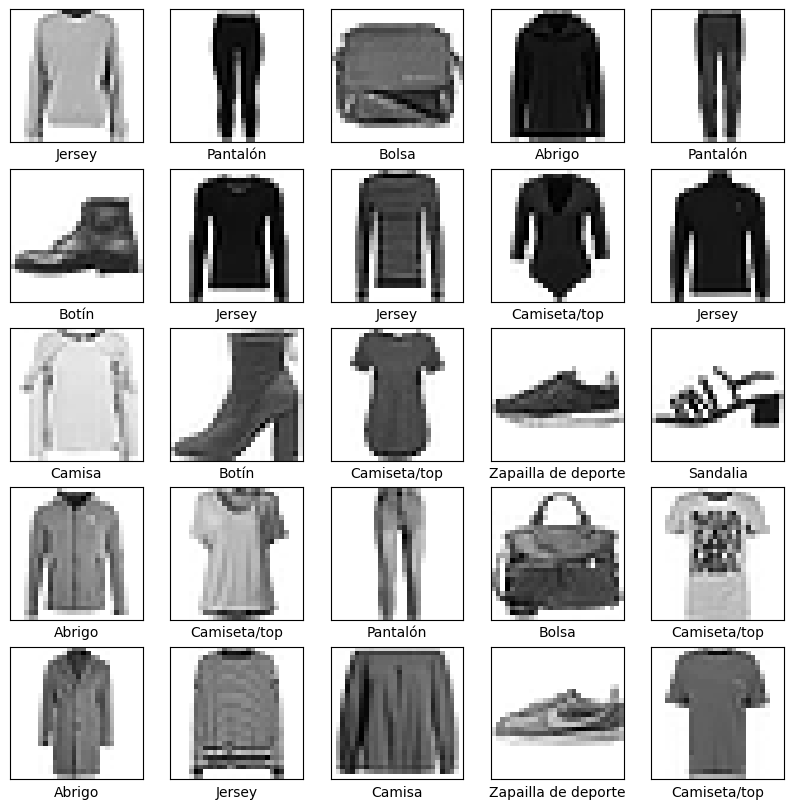

In [ ]:
#--------------------------------------------------------------------------------
# Dibujamos ahora más
#--------------------------------------------------------------------------------
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [ ]:
#--------------------------------------------------------------------------------
# Crear el modelo Denso
#--------------------------------------------------------------------------------
modeloDenso = tf.keras.Sequential([
  tf.keras.layers.Flatten( input_shape = (28,28,1)), #1 - blanco y negro
  tf.keras.layers.Dense( 50, activation = 'relu' ),
  tf.keras.layers.Dense( 50, activation = 'relu' ),
  tf.keras.layers.Dense( 10, activation = 'softmax' ) #Para redes de clasificacion
])

#--------------------------------------------------------------------------------
# Creamos el modelo Convolucional
#--------------------------------------------------------------------------------
modeloConvolucional = tf.keras.Sequential([
  tf.keras.layers.Conv2D( 32, ( 3, 3 ), input_shape = ( 28, 28, 1 ), activation = 'relu' ),
  tf.keras.layers.MaxPooling2D( 2, 2 ),             # 2,2 es el tamano de la matriz
  tf.keras.layers.Dropout( 0.25 ),

  tf.keras.layers.Conv2D( 64, ( 3, 3 ), activation = 'relu' ),
  tf.keras.layers.MaxPooling2D( 2, 2 ),             # 2,2 es el tamano de la matriz
  tf.keras.layers.Dropout( 0.25 ),

  tf.keras.layers.Flatten(),      # Aplanamiento
  tf.keras.layers.Dense( 50, activation = 'relu' ),
  tf.keras.layers.Dense( 10, activation = 'softmax' )
])

In [ ]:
#--------------------------------------------------------------------------------
# Compilamos los modelos Denso y Convolucional
#--------------------------------------------------------------------------------
modeloDenso.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

modeloConvolucional.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
#--------------------------------------------------------------------------------
# Los numeros de datos en entrenamiento y pruebas (60k y 10k)
#--------------------------------------------------------------------------------
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples
print(num_ej_entrenamiento)
print(num_ej_pruebas)

60000
10000


In [ ]:
#--------------------------------------------------------------------------------
# El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
#--------------------------------------------------------------------------------
TAMANO_LOTE = 32 #8  #32

#--------------------------------------------------------------------------------
# Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
# no se vaya a aprender el orden de las cosas
#--------------------------------------------------------------------------------
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [ ]:
import math
ACIERTO = 0.95

print( 'Entrenando la red Densa ...' )
#--------------------------------------------------------------------------------
# Entrenamos ahora el modelo Denso
#--------------------------------------------------------------------------------
historial = modeloDenso.fit(datos_entrenamiento, epochs = 1, steps_per_epoch = math.ceil(num_ej_entrenamiento/TAMANO_LOTE))
while( historial.history[ 'accuracy' ][0] < ACIERTO ):
    historial = modeloDenso.fit(datos_entrenamiento, epochs = 1, steps_per_epoch = math.ceil(num_ej_entrenamiento/TAMANO_LOTE))
print( 'Fin del entrenamiento de la red Densa.' )

print( 'Entrenando la red Convolucional ...' )
#--------------------------------------------------------------------------------
# Entrenamos ahora el modelo Convolucional
#--------------------------------------------------------------------------------
historial = modeloConvolucional.fit(datos_entrenamiento, epochs = 1, steps_per_epoch = math.ceil(num_ej_entrenamiento/TAMANO_LOTE))
while( historial.history[ 'accuracy' ][0] < ACIERTO ):
    historial = modeloConvolucional.fit(datos_entrenamiento, epochs = 1, steps_per_epoch = math.ceil(num_ej_entrenamiento/TAMANO_LOTE))
print( 'Fin del entrenamiento de la red Convolucional.' )

Entrenando la red Densa ...
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1315 - accuracy: 0.9502
Fin del entrenamiento de la red Densa.
Entrenando la red Convolucional ...
1875/1875 [==============================] - 32s 17ms/step - loss: 0.1291 - accuracy: 0.9516
Fin del entrenamiento de la red Convolucional.


In [ ]:
#--------------------------------------------------------------------------------
# Definimos las funciones asociadas a mostrar las predicciones con color azul (correcta) o roja (errónea)
#--------------------------------------------------------------------------------
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(10):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  prediccionesDenso         = modeloDenso.predict(         imagenes_prueba )
  prediccionesConvolucional = modeloConvolucional.predict( imagenes_prueba )

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

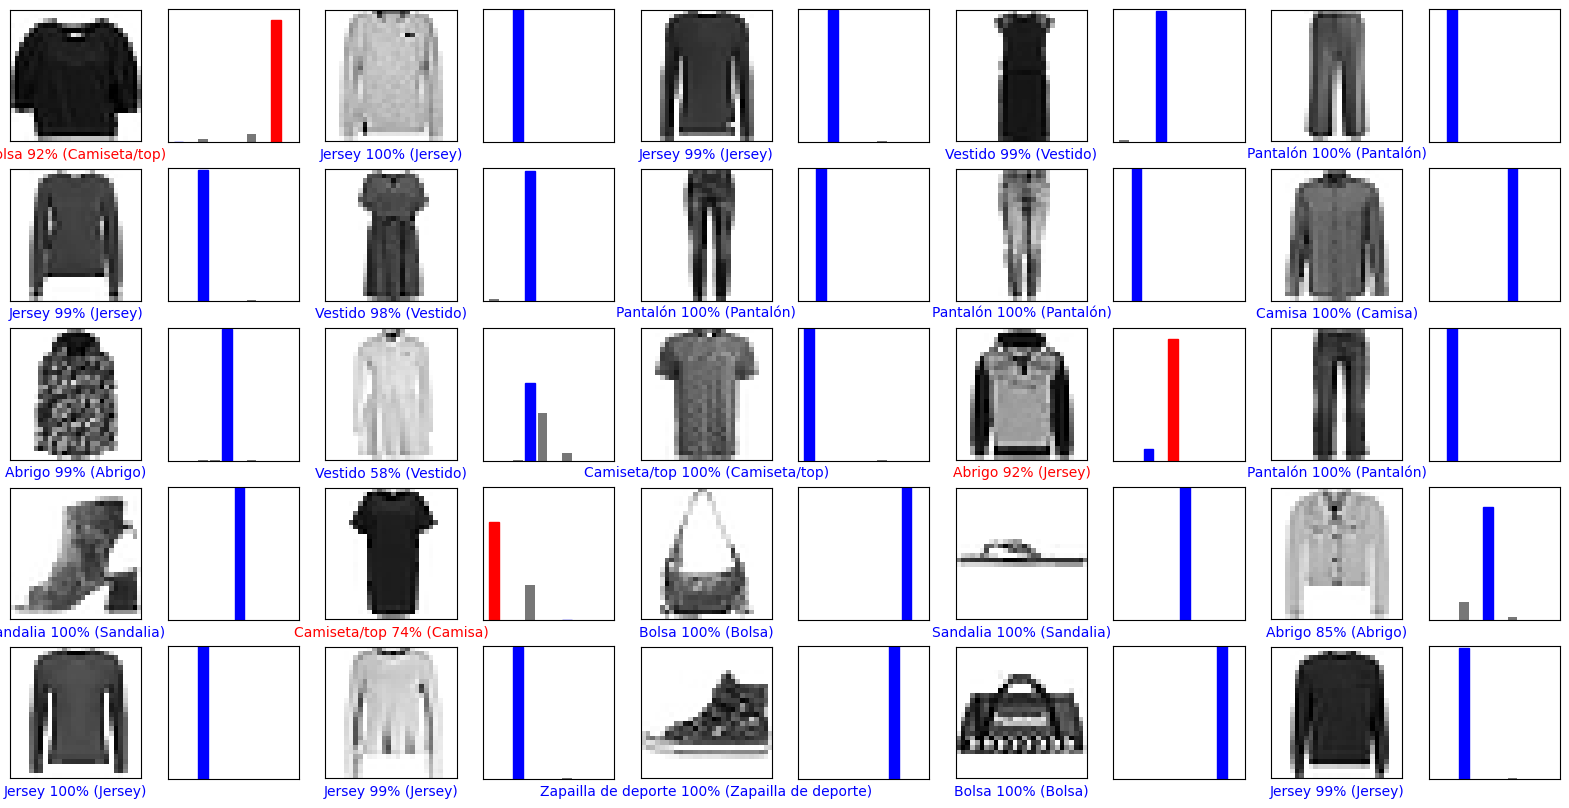

In [ ]:
#--------------------------------------------------------------------------------
# Mostramos ahora las predicciones con el modelo Denso
#--------------------------------------------------------------------------------
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, prediccionesDenso, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, prediccionesDenso, etiquetas_prueba)

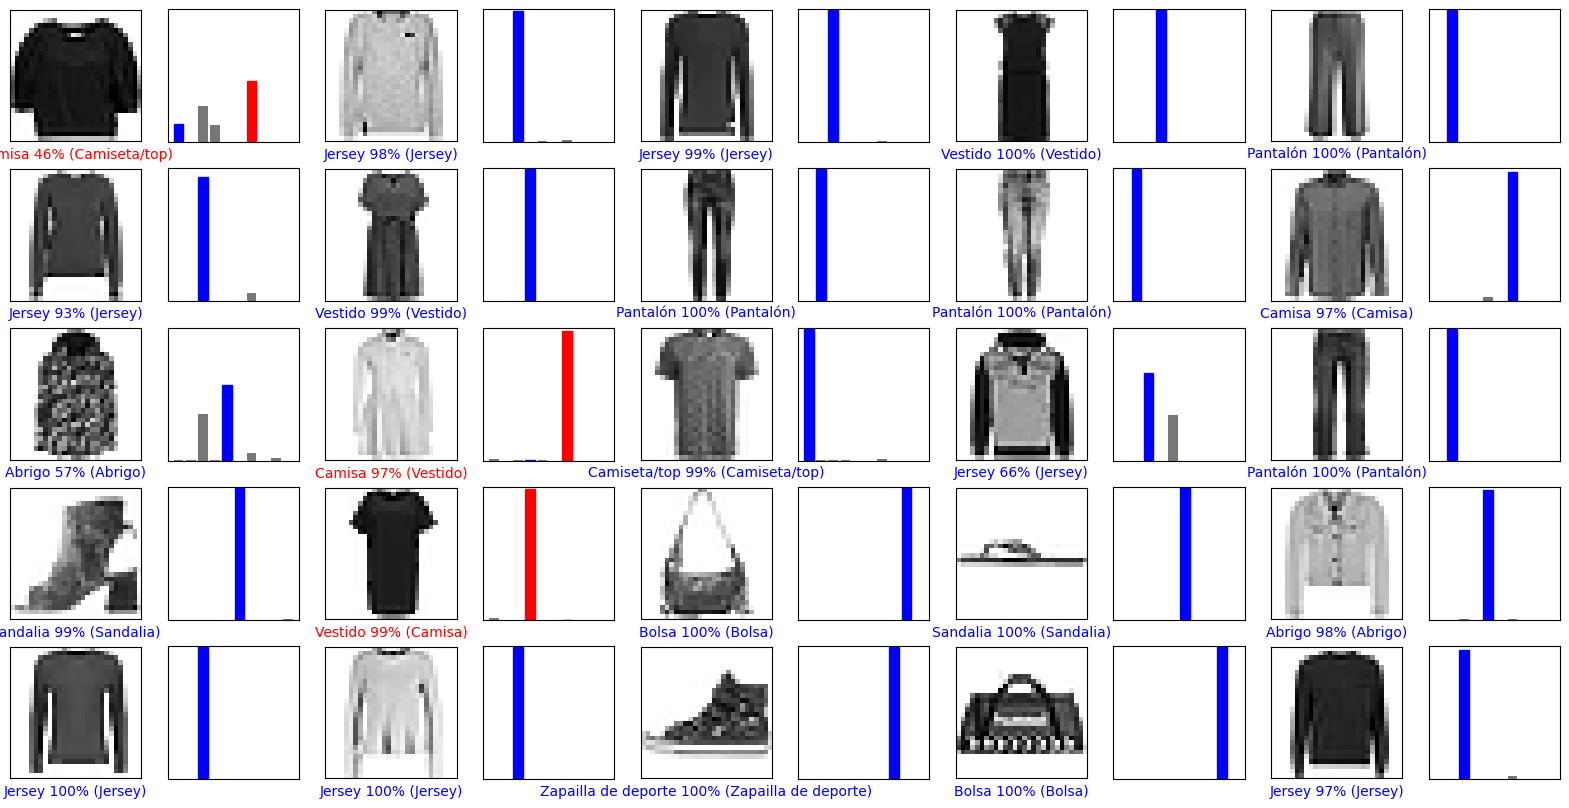

In [ ]:
#--------------------------------------------------------------------------------
# Mostramos ahora las predicciones con el modelo Convolucional
#--------------------------------------------------------------------------------
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, prediccionesConvolucional, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, prediccionesConvolucional, etiquetas_prueba)

In [ ]:
#--------------------------------------------------------------------------------
# Probar una imagen suelta
#--------------------------------------------------------------------------------
imagen = imagenes_prueba[14] #AL ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior heheh
imagen = np.array([imagen])
prediccion = modeloDenso.predict(imagen)
print( "Prediccion: " + nombres_clases[np.argmax(prediccion[0])])
prediccion = modeloConvolucional.predict(imagen)
print( "Prediccion: " + nombres_clases[np.argmax(prediccion[0])])


1/1 [==============================] - 0s 52ms/step
Prediccion: Pantalón
1/1 [==============================] - 0s 77ms/step
Prediccion: Pantalón


In [ ]:
#Exportacion del modelo a h5
modeloDenso.save( "modeloDenso.h5" )
modeloConvolucional.save()

tf.saved_model.save(modeloDenso, "modeloDenso_guardado" )
tf.saved_model.save(modeloConvolucional, "modeloConvolucional_guardado" )

In [ ]:
#Instalar tensorflowjs para convertir el h5 a un modelo que pueda cargar tensorflowjs en un explorador
!pip install tensorflowjs

In [22]:
#Convertir el archivo h5 a formato de tensorflowjs
!mkdir tfjs_target_dir
!tensorflowjs_converter --input_format keras modelo_exportado.h5 tfjs_target_dir

2024-03-08 16:18:19.007901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 16:18:19.007963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 16:18:19.008935: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 16:18:20.627197: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 958, in pip_main
    

In [23]:
#Veamos si si creo la carpeta
!ls

modeloConvolucional_guardado  modeloDenso_guardado  sample_data
modeloConvolucional.h5	      modeloDenso.h5	    tfjs_target_dir


In [24]:
#Veamos el contenido de la carpeta
!ls tfjs_target_dir

In [25]:
#modelo_cargado = tf.keras.models.load_model( 'modeloDenso.h5' )
modelo_cargado = tf.keras.models.load_model( 'modeloConvolucional.h5' )

#modelo_cargado = tf.saved_model.load( "modeloDenso_guardado" )
#modelo_cargado = tf.saved_model.load( "modeloConvolucional_guardado" )
modelo_cargado

1/1 [==============================] - 0s 17ms/step


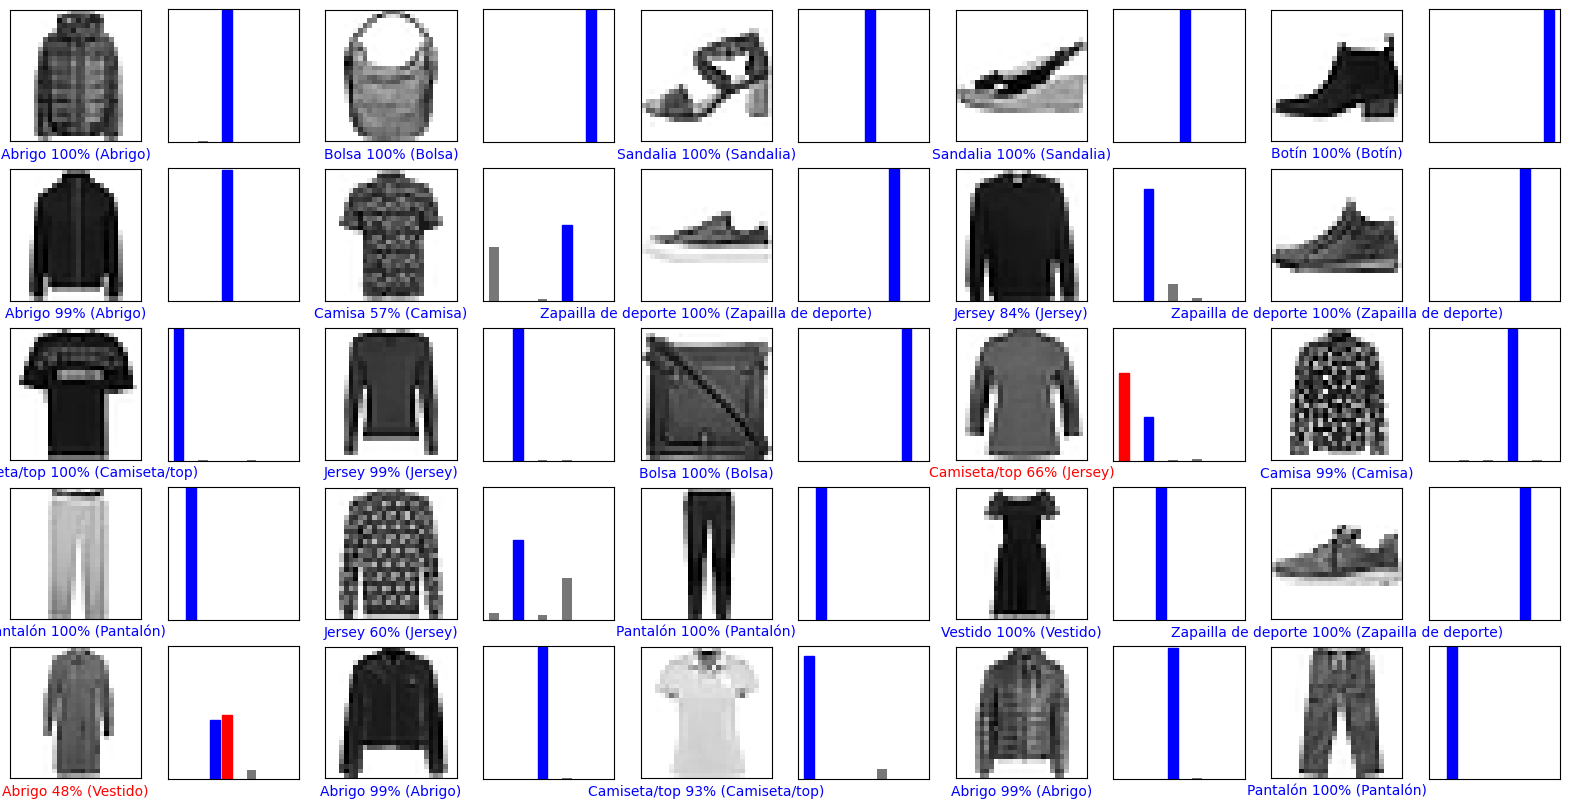

In [28]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(20):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo_cargado.predict(imagenes_prueba)

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)

def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1])
  etiqueta_prediccion = np.argmax(arr_predicciones)

  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')

filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)